# Reproducibility Lab: Functional Connectivity and Behavior

## EXPLORATORY ANALYSIS

## Learning Objectives

By the end of this lab, you will be able to:
- Explore functional connectivity data from a real brain atlas (216 regions, 23,220 edges)
- Test brain-behavior relationships across thousands of connectivity edges
- Discover how analytic flexibility affects statistical findings
- Validate your findings in an independent dataset
- Present your strongest discoveries to the class

## Background: Functional Connectivity

**Functional connectivity (FC)** measures how correlated the activity is between two brain regions during a resting-state fMRI scan. When two regions show correlated activity over time, we say they are "functionally connected."

In this lab, you have FC data from a brain atlas with **216 regions of interest (ROIs)** organized into **8 brain networks**. For every pair of ROIs, we have a connectivity value for each subject -- that gives us **23,220 unique edges** (connections) to analyze.

Your goal is to find edges whose connectivity strength predicts individual differences in a behavioral outcome (pain sensitivity, depression severity, or anxiety level, depending on your assigned topic).

### Brain Networks

The 216 ROIs are organized into networks based on the Schaefer 200-parcel cortical atlas plus Tian subcortical atlas:

| Network | Description |
|---------|------------|
| Subcortical | Hippocampus, amygdala, thalamus, basal ganglia |
| Visual | Central and peripheral visual areas |
| Somatomotor | Primary motor and somatosensory cortex |
| Dorsal Attention | Top-down attention control (focusing on tasks) |
| Salience | Detecting important stimuli, switching between networks |
| Limbic | Emotion processing, memory |
| Frontoparietal | Executive function, cognitive control |
| Default Mode | Self-referential thought, mind-wandering |


---

## Part 1: Set Your Topic

Your instructor has assigned you one of three topics. Set the `TOPIC` variable below to match your assignment.

In [1]:
# SET YOUR TOPIC HERE (change this to match your assignment)
# Options: 'pain', 'depression', or 'anxiety'

TOPIC = 'depression'

## Part 2: Setup and Load Data

Run the cells below to download the data files and load your dataset.

In [3]:
# Install packages for brain visualizations and statistical corrections
import subprocess, sys
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'nilearn', 'statsmodels', '-q'])

import os
import urllib.request

base_url = 'https://raw.githubusercontent.com/cmahlen/python-stats-demo/main/'
files_needed = [
    'lab_helpers.py',
    'atlas_labels.txt',
    'data/roi_mni_coords.npy',
    f'data/{TOPIC}_discovery.npz',
    f'data/{TOPIC}_validation.npz',
]

os.makedirs('data', exist_ok=True)
for f in files_needed:
    if not os.path.exists(f):
        print(f'Downloading {f}...')
        urllib.request.urlretrieve(base_url + f, f)

print('Setup complete!')


Setup complete!



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip3.11 install --upgrade pip


In [5]:
import lab_helpers as helpers

# Load the discovery dataset
helpers.load_dataset(TOPIC, 'discovery')

Loaded depression discovery dataset:
  200 subjects
  216 brain regions (ROIs)
  23,220 connectivity edges
  Outcome variable: PHQ9
  Other variables: Age, Sex, BMI, HRV, Sleep_Quality, Physical_Activity, Caffeine_mg, Stress_Level, Rumination, Loneliness, Social_Support, Neuroticism, Self_Esteem, Alcohol_drinks, Screen_Time, Social_Media, Education_yrs, Income_k


**Tip: Exploring the `helpers` module**

All the pre-built functions in this lab are accessed through `helpers`. Two useful ways to discover what is available:

- **Tab completion:** In any code cell, type `helpers.` and press **Tab**. Colab will show a dropdown of all available functions.
- **Function documentation:** Run `help(helpers.plot_edge)` in a code cell to see what arguments any function accepts and what it does. Replace `plot_edge` with any function name. Run `help(helpers)` to see everything at once.

**A note on Colab's AI tools:** You are welcome to use Colab's built-in AI features (Gemini) to understand code or debug errors. However, your **analytical decisions** -- which networks to test, whether to apply corrections, whether to use covariates or outlier removal -- should be your own. These choices are the point of the lab. This mirrors best practices in real research: AI is a tool to support your thinking, not replace it. If you are unsure whether something is appropriate to use AI for, ask Caleb.

---

## Part 3: Peek at the Data

Before running any statistical tests, let's look at what we actually have. This is a crucial first step in any analysis -- understand your data before analyzing it.

First, let's see what variables are available and what they measure:

In [7]:
# What variables do we have? Print descriptions and units for each one.
helpers.describe_variables()

Variables in the depression dataset:
Variable                       Description
---------------------------------------------------------------------------
PHQ9                           Depression severity (PHQ-9 questionnaire, 0-27)
Age                            Age in years
Sex                            Biological sex (0 = female, 1 = male)
BMI                            Body mass index (kg/m^2)
HRV                            Heart rate variability (RMSSD, ms)
Sleep_Quality                  Sleep quality (PSQI, 0-21; higher = worse sleep)
Physical_Activity              Physical activity (minutes/week)
Caffeine_mg                    Caffeine intake (mg/day)
Stress_Level                   Perceived stress (PSS, 0-40)
Rumination                     Rumination (RRS, 22-88)
Loneliness                     Loneliness (UCLA scale, 20-80)
Social_Support                 Perceived social support (MSPSS, 12-60)
Neuroticism                    Neuroticism (NEO, 0-48)
Self_Esteem                

In [9]:
# Look at the first few rows of behavioral data
# Each row is one subject; columns are their scores on different measures
behavior = helpers.get_behavior()
behavior = behavior.astype(float).round(3)
behavior.head().round(1)

,PHQ9,Age,Sex,BMI,HRV,Sleep_Quality,Physical_Activity,Caffeine_mg,Stress_Level,Rumination,Loneliness,Social_Support,Neuroticism,Self_Esteem,Alcohol_drinks,Screen_Time,Social_Media,Education_yrs,Income_k
0,3.7,38.7,0.0,28.2,68.0,15.1,90.3,128.9,18.2,40.0,46.0,27.8,26.4,17.9,14.0,4.6,101.7,12.1,53.4
1,8.0,21.7,0.0,22.8,47.0,11.6,13.6,128.0,24.4,40.9,45.9,31.9,39.2,15.4,13.3,5.1,123.5,16.2,46.5
2,3.5,22.3,1.0,17.6,49.8,19.2,106.3,145.1,21.7,36.9,31.7,27.3,25.0,30.0,7.3,2.1,77.5,14.8,10.0
3,13.5,57.1,0.0,26.3,42.8,10.1,189.5,123.5,19.9,70.9,56.9,25.8,24.9,15.6,6.2,5.5,126.8,16.9,73.3
4,16.6,38.5,1.0,21.6,70.6,8.8,99.4,395.2,14.3,48.1,35.8,21.6,38.4,13.7,4.3,11.0,184.1,17.2,27.7


In [11]:
# Summary statistics for all variables
# Look at the mean, standard deviation, min, and max for each variable
behavior.describe().round(1)

,PHQ9,Age,Sex,BMI,HRV,Sleep_Quality,Physical_Activity,Caffeine_mg,Stress_Level,Rumination,Loneliness,Social_Support,Neuroticism,Self_Esteem,Alcohol_drinks,Screen_Time,Social_Media,Education_yrs,Income_k
count,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0
mean,8.2,37.9,0.5,26.9,53.7,9.9,129.8,219.5,20.1,44.5,42.9,27.8,27.4,19.0,6.3,7.2,110.1,14.0,49.3
std,5.5,12.9,0.5,5.3,13.3,3.8,56.1,113.2,7.2,12.3,11.3,8.6,8.9,6.0,4.2,3.0,50.0,2.3,20.9
min,0.0,18.0,0.0,15.0,10.0,0.3,0.0,0.0,0.9,22.0,20.0,12.0,0.0,4.4,0.0,0.0,0.0,10.0,10.0
25%,3.5,28.3,0.0,23.1,45.5,6.9,88.6,137.0,15.0,36.7,35.7,22.1,22.7,14.9,2.6,5.2,78.6,12.4,34.1
50%,8.0,38.4,0.5,26.8,54.2,9.8,132.2,208.1,19.6,44.9,42.5,26.8,27.7,19.5,6.3,7.3,108.7,14.0,47.7
75%,12.7,46.4,1.0,30.9,62.5,12.7,168.3,300.2,25.0,52.4,50.5,33.6,32.7,23.2,9.6,9.3,146.1,15.3,64.1
max,21.9,70.0,1.0,44.1,97.0,21.0,257.9,504.7,37.5,81.0,71.6,50.7,48.0,30.0,15.9,15.3,258.4,20.5,107.1


Each row in the `behavior` datafrmae is one subject. You have behavioral outcome scores and several demographic/clinical variables.

**Tip:** To get a single column as its own variable, use square brackets: `behavior['PHQ9']` or `behavior['Age']`. You can also use `helpers.get_behavior('PHQ9')` directly.

---

## Part 4: Visualize Before Testing

Before running any statistical tests, always plot your data first. Visualizations help you spot patterns, outliers, and potential problems that numbers alone might miss.

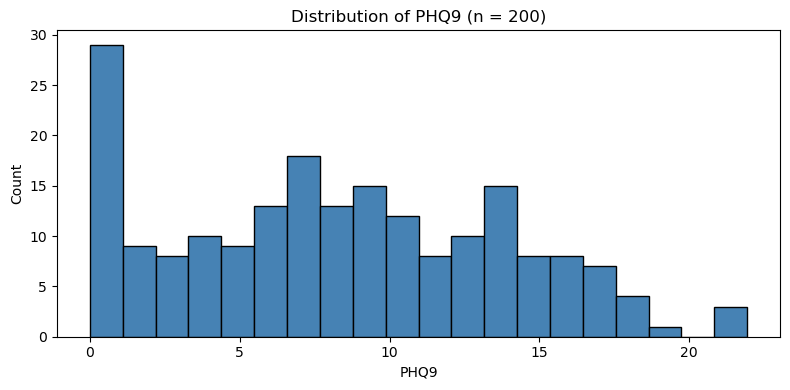

This shows how PHQ9 is distributed across your 200 subjects.


In [14]:
import matplotlib.pyplot as plt

# The first column is always the main outcome variable for your topic
OUTCOME = behavior.columns[0]

plt.figure(figsize=(8, 4))
plt.hist(behavior[OUTCOME], bins=20, color='steelblue', edgecolor='black')
plt.xlabel(OUTCOME)
plt.ylabel('Count')
plt.title(f'Distribution of {OUTCOME} (n = {len(behavior)})')
plt.tight_layout()
plt.show()

print(f"This shows how {OUTCOME} is distributed across your {len(behavior)} subjects.")

---

## Part 5: Explore the Brain Networks

Now that you have a sense of the data, let's explore the brain networks and regions available to you.

In [16]:
# What brain networks are available?
helpers.list_networks()

Brain networks in the depression dataset:
Network                ROIs
----------------------------
Subcortical              16
Visual                   24
Somatomotor              34
Dorsal Attention         22
Salience                 26
Limbic                   14
Frontoparietal           37
Default Mode             43
----------------------------
Total                   216


Each network contains several brain areas called regions or regions of interest (ROIs). Let's list them out for an example network.

In [19]:
# What regions are in a specific network?
# Try changing the network name to explore different ones
helpers.list_regions('Salience')

ROIs in Salience:
  [ 55] LH_SalVentAttnA_ParOper_1                          (Salience)
  [ 56] LH_SalVentAttnA_Ins_1                              (Salience)
  [ 57] LH_SalVentAttnA_FrOper_1                           (Salience)
  [ 58] LH_SalVentAttnA_FrOper_2                           (Salience)
  [ 59] LH_SalVentAttnA_ParMed_1                           (Salience)
  [ 60] LH_SalVentAttnA_FrMed_1                            (Salience)
  [ 61] LH_SalVentAttnA_FrMed_2                            (Salience)
  [ 62] LH_SalVentAttnB_IPL_1                              (Salience)
  [ 63] LH_SalVentAttnB_PFCl_1                             (Salience)
  [ 64] LH_SalVentAttnB_Ins_1                              (Salience)
  [ 65] LH_SalVentAttnB_PFCmp_1                            (Salience)
  [157] RH_SalVentAttnA_ParOper_1                          (Salience)
  [158] RH_SalVentAttnA_PrC_1                              (Salience)
  [159] RH_SalVentAttnA_Ins_1                              (Salience)
  

You can also visualize the connectivity within a specific network using `helpers.plot_network_matrix()`:

```python
helpers.plot_network_matrix('Default Mode')
helpers.plot_network_matrix('Subcortical')
```

In [22]:
# Your Turn: try visualizing different networks here


### Understanding ROI Names

The region names follow a naming convention. Here's how to decode a cortical ROI name:

```
LH_SalVentAttnA_Ins_1
│   │             │ │
│   │             │ └── parcel number (multiple parcels per subregion)
│   │             └────── subregion: Ins = Insula
│   └──────────────────── sub-network: SalVentAttnA 
└──────────────────────── hemisphere: LH = left, RH = right
```

The sub-network names (like DefaultA, DefaultB, SalVentAttnA, SalVentAttnB, etc.) come from the Schaefer atlas, which defined 17 fine-grained sub-networks. For simplicity, we group these into **8 broader display networks** (Default Mode, Salience, etc.) that you saw in `list_networks()`. The sub-network names are still visible in the ROI names and can be useful for more targeted analyses.

Subcortical regions use shorter names like `HIP-lh` (left hippocampus) or `NAc-rh` (right nucleus accumbens).

Use `helpers.describe_regions()` to see decoded descriptions for all regions:

In [25]:
# See decoded region names for any network
helpers.describe_regions('Subcortical')

Regions in Subcortical (decoded):
  Name                                               Hemisphere Network            Region
  -----------------------------------------------------------------------------------------------
  HIP-rh                                             Right  Subcortical        Hippocampus
  AMY-rh                                             Right  Subcortical        Amygdala
  pTHA-rh                                            Right  Subcortical        Posterior thalamus
  aTHA-rh                                            Right  Subcortical        Anterior thalamus
  NAc-rh                                             Right  Subcortical        Nucleus accumbens
  GP-rh                                              Right  Subcortical        Globus pallidus
  PUT-rh                                             Right  Subcortical        Putamen
  CAU-rh                                             Right  Subcortical        Caudate
  HIP-lh                              

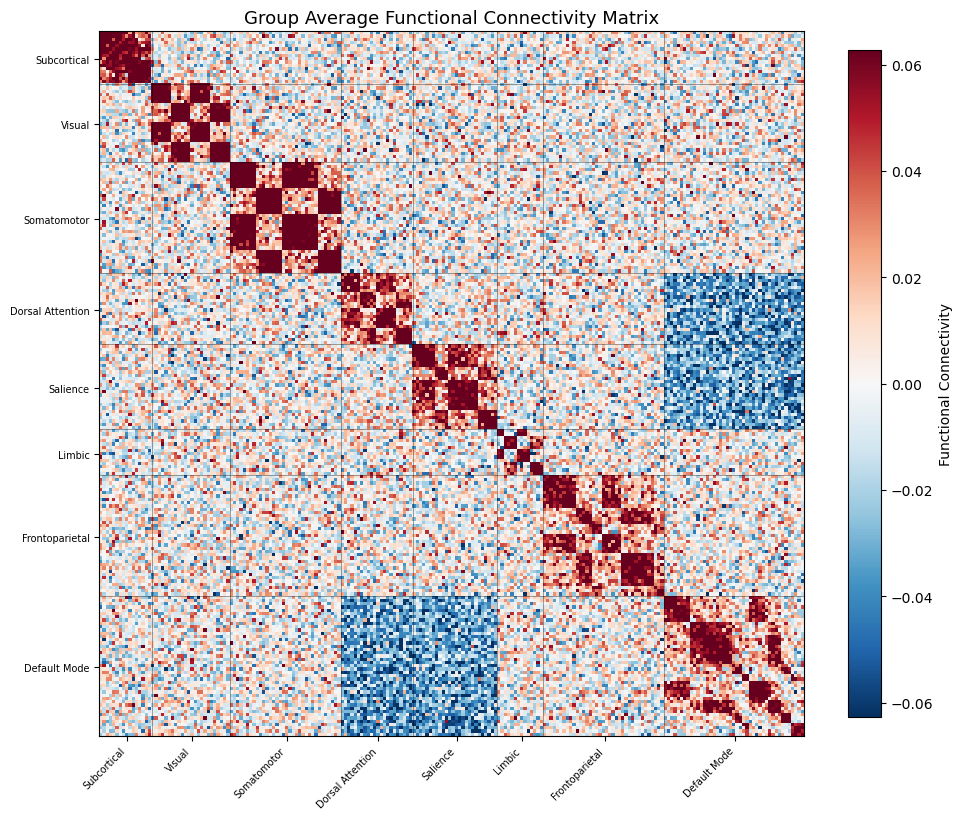

In [27]:
# Visualize the overall connectivity structure
# This heatmap shows which networks tend to be connected to each other
helpers.plot_connectome()

Take some time to think about **why the group connectome has this shape**: why are there some areas that are mostly blue? Why are some areas very red compared to others?

The brain connectivity data is stored separately. For every pair of brain regions, you have a **connectivity value** for each subject -- a number telling you how correlated those two regions' activity was during a brain scan. Let's look at what one of those values looks like:

In [31]:
# Get the connectivity values between the hippocampus and amygdala
# ROI names use abbreviations: HIP = hippocampus, AMY = amygdala
# The suffix tells you the hemisphere: lh = left, rh = right
edge = helpers.get_edge('HIP-lh', 'AMY-rh')


In [33]:
# use edge[:10] to see the first few values
# edge.shape to see the dimension
# and/or, try making a quick plot with plt.hist(edge)
# make sure you know what each value represents! 


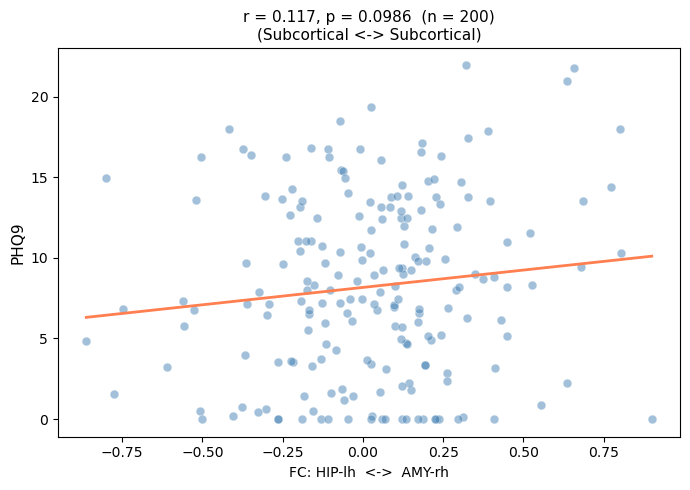

In [35]:
# Now visualize the relationship between one brain edge and your outcome
# plot_edge() makes a scatter plot with a regression line
helpers.plot_edge('HIP-lh', 'AMY-rh')

Each dot is one subject. The x-axis shows connectivity strength between those two regions, and the y-axis shows their behavioral score. The line shows the best linear fit, and the **r** and **p** values tell you how strong the relationship is and whether it's statistically significant.

### Understanding Correlation (Pearson r)

Every scatter plot above shows a **Pearson r** value. This measures the strength of the linear relationship between two variables:

- **r = +1.0**: perfect positive relationship (as one goes up, the other always goes up)
- **r = 0.0**: no linear relationship
- **r = -1.0**: perfect negative relationship (as one goes up, the other always goes down)

In brain-behavior research, correlations are usually small:
- |r| < 0.10 — negligible
- |r| around 0.10–0.20 — small
- |r| around 0.20–0.30 — medium
- |r| > 0.30 — large (rare in neuroimaging)

Another useful way to think about it: **r-squared** (r x r) tells you the proportion of variance explained. An r of 0.20 means r-squared = 0.04, so the brain connection explains about 4% of the individual differences in the outcome.

### Your Turn: Explore Different Edges and Variables

Try plotting different brain regions against different behavioral variables. You can change the region names and add a `behavior_col` argument to `plot_edge()`.

<details>
<summary>Hint: Example code</summary>

```python
# Plot a different pair of regions
helpers.plot_edge('NAc-rh', 'AMY-lh')

# Plot against a different behavioral variable (e.g., 'Age', 'Stress_Level', 'HRV')
helpers.plot_edge('HIP-lh', 'AMY-rh', behavior_col='Stress_Level')

# Plot against another variable to see if the same edge predicts different things
helpers.plot_edge('HIP-lh', 'AMY-rh', behavior_col='Age')
```

Use `helpers.list_regions('Subcortical')` to see available region names.
</details>

In [40]:
# Your Turn: try different behavioral variables here


---

## Part 6: Test Brain-Behavior Relationships

Now let's systematically test whether any brain connections predict your behavioral outcome. With 23,220 edges to test, we need to think carefully about which ones to focus on and how to handle false positives.

### From Individual Edges to Mass Testing

You've looked at a few edges by hand. But there are **23,220 edges** in this dataset. Testing them one by one would take forever.

Let's test them all at once and find the ones with the strongest correlations.

**Quick thought experiment:** If there were NO real brain-behavior relationships at all -- if every edge were pure random noise -- how many would you expect to be "significant" at p < 0.05? (Keep your guess in mind as you look at the results.)

**<span style="color:red">IMPORTANT: Before you generate any results, make sure you note ANYTHING you find interesting down. Everyone tends to think they will remember everything, but they do not. You can easily lose a result by re-running the cell after something is changed and not be able to get it back. It sounds corny and stereotypically "science-nerd", but keep a lab notebook (even if it's just a note in your computer). </span>**

**It is much better to over-document than it is to under-document. You will thank yourself when you are making your presentation for next week.**

Thank you for your attention to this matter.

In [45]:
# Test ALL edges vs your outcome variable
results = helpers.test_all_edges()

# Show the top 20 findings
print("\nTop 20 findings (sorted by p-value):")
results.head(20)

Testing all edges vs PHQ9...
Done! 23,220 edges tested (200 subjects).
  Significant at p < 0.05 (uncorrected): 1,148

Top 20 findings (sorted by p-value):


,ROI_A,ROI_B,r,p,network_A,network_B
0,RH_SomMotB_Aud_1,RH_DefaultB_Temp_1,-0.285475,0.000042,Somatomotor,Default Mode
1,LH_VisCent_ExStr_3,RH_SomMotB_S2_4,0.270998,0.000104,Visual,Somatomotor
2,LH_VisPeri_ExStrInf_1,RH_ContB_IPL_2,-0.270743,0.000106,Visual,Frontoparietal
3,LH_DefaultB_PFCd_3,LH_TempPar_2,-0.264681,0.000152,Default Mode,Default Mode
4,LH_VisCent_ExStr_1,LH_ContA_PFCl_3,0.257823,0.000228,Visual,Frontoparietal
5,RH_DorsAttnB_PostC_4,RH_DefaultA_PFCm_3,-0.257511,0.000232,Dorsal Attention,Default Mode
6,LH_ContC_pCun_1,RH_SalVentAttnA_FrMed_2,-0.246659,0.000430,Frontoparietal,Salience
7,RH_DorsAttnA_SPL_3,RH_SalVentAttnB_Ins_2,-0.244352,0.000488,Dorsal Attention,Salience
8,LH_LimbicA_TempPole_4,LH_ContC_pCun_2,-0.243499,0.000512,Limbic,Frontoparietal
9,NAc-rh,RH_VisPeri_ExStrSup_3,0.243201,0.000520,Subcortical,Visual


In [46]:
# How many edges are "significant"?
n_sig = (results['p'] < 0.05).sum()
n_total = len(results)
print(f"Significant at p < 0.05: {n_sig:,} out of {n_total:,} edges")
print(f"That's {n_sig/n_total*100:.1f}% of all edges tested")

Significant at p < 0.05: 1,148 out of 23,220 edges
That's 4.9% of all edges tested


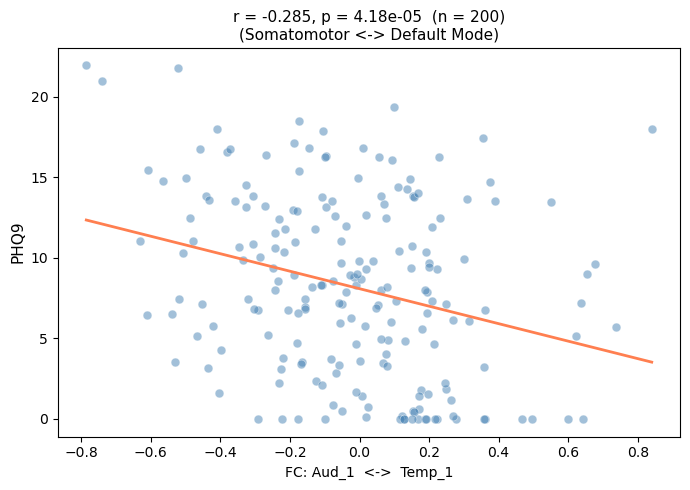

In [49]:
# Visualize your strongest finding
top = results.iloc[0]
helpers.plot_edge(top['ROI_A'], top['ROI_B'])

### Visualize Your Findings on a Glass Brain

A "glass brain" plot shows brain connections drawn on a transparent brain template. Each colored dot is a brain region (colored by network), and each line is a significant connection. Red lines indicate positive correlations; blue lines indicate negative correlations.

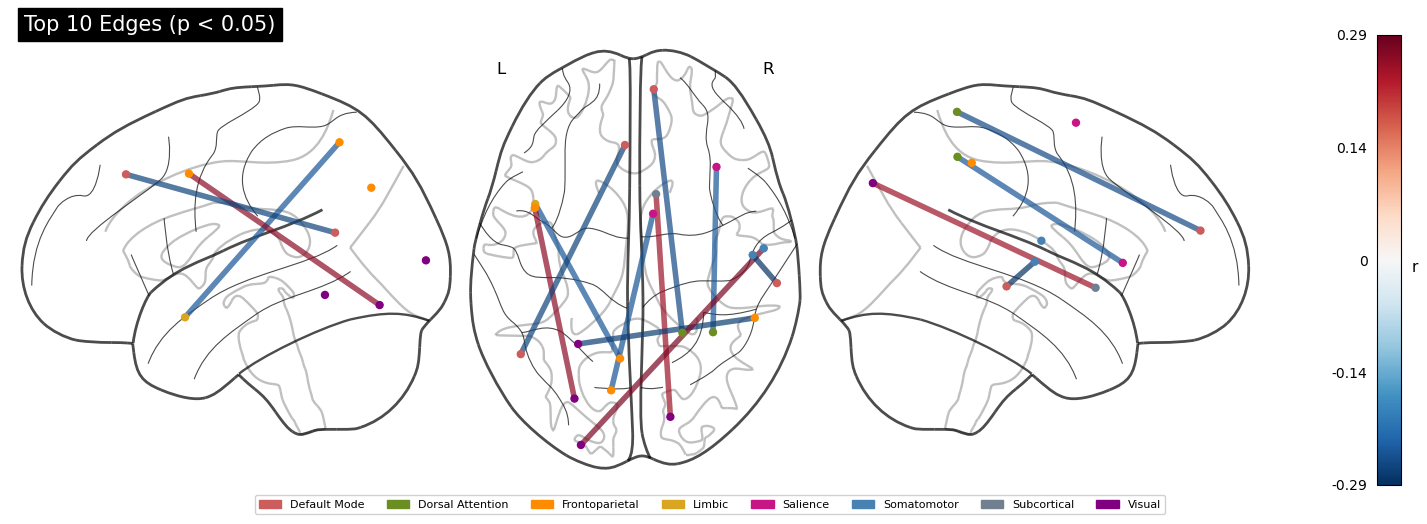

In [52]:
# Visualize your top findings on a glass brain
helpers.plot_glass_brain(results, n_top=10)

### The Multiple Comparisons Problem

When you test 23,220 edges, some will be "significant" purely by chance. At p < 0.05, you expect about 5% of tests to be false positives -- even if there are NO real effects at all. Let's see what this looks like.

THE MULTIPLE COMPARISONS PROBLEM

You tested 5,000 edges at p < 0.05
Expected FALSE POSITIVES by chance alone: ~250
Actual 'significant' findings: 402

Most of those are likely noise, not real brain-behavior relationships!


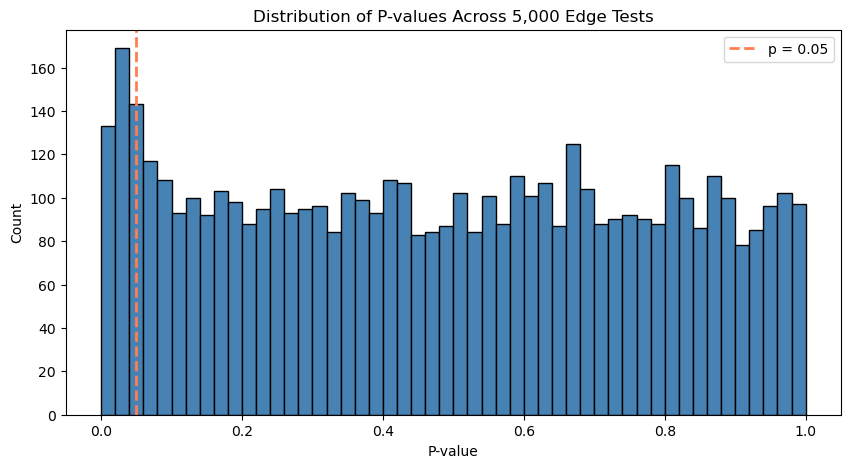

In [104]:
import matplotlib.pyplot as plt

n_tests = len(results)
alpha = 0.05
expected_fp = n_tests * alpha
actual_sig = (results['p'] < 0.05).sum()

print("=" * 60)
print("THE MULTIPLE COMPARISONS PROBLEM")
print("=" * 60)
print(f"\nYou tested {n_tests:,} edges at p < {alpha}")
print(f"Expected FALSE POSITIVES by chance alone: ~{expected_fp:,.0f}")
print(f"Actual 'significant' findings: {actual_sig:,}")
print(f"\nMost of those are likely noise, not real brain-behavior relationships!")

# Visualize the p-value distribution
plt.figure(figsize=(10, 5))
plt.hist(results['p'], bins=50, edgecolor='black', color='steelblue')
plt.axvline(0.05, color='coral', linestyle='--', linewidth=2, label='p = 0.05')
plt.xlabel('P-value')
plt.ylabel('Count')
plt.title(f'Distribution of P-values Across {len(results):,} Edge Tests')
plt.legend()
plt.show()

If there were NO real effects, the histogram would be perfectly flat (uniform). Any bump near 0 suggests some real signal -- but most of those "significant" edges at p < 0.05 are still false positives.

### Correction Methods: Bonferroni and FDR

There are standard statistical methods to correct for multiple comparisons:

- **Bonferroni correction**: Divide your significance threshold by the number of tests. With 23,220 tests, the threshold becomes 0.05 / 23,220 = 0.0000022. Very strict -- controls the chance of ANY false positive.
- **FDR (False Discovery Rate)**: Controls the expected PROPORTION of false positives among your significant results. Less strict than Bonferroni -- allows more true positives through, at the cost of tolerating a small fraction of false positives.

Let's apply both corrections to our results:

In [100]:
# We already ran test_all_edges() above. Let's apply corrections to those results.
from statsmodels.stats.multitest import multipletests
import numpy as np

n_tests = len(results)

# Bonferroni: multiply each p-value by the number of tests
results_bonf = results.copy()
results_bonf['p_corrected'] = np.minimum(results['p'] * n_tests, 1.0)
n_bonf = (results_bonf['p_corrected'] < 0.05).sum()

# FDR (Benjamini-Hochberg): less strict, controls the proportion of false discoveries
_, p_fdr, _, _ = multipletests(results['p'].values, alpha=0.05, method='fdr_bh')
results_fdr = results.copy()
results_fdr['p_corrected'] = p_fdr
n_fdr = (results_fdr['p_corrected'] < 0.05).sum()

n_uncorrected = (results['p'] < 0.05).sum()

print("=" * 60)
print("SUMMARY: Corrections applied to all {:,} edges".format(n_tests))
print("=" * 60)
print(f"  Uncorrected p < 0.05:     {n_uncorrected:,}")
print(f"  Surviving Bonferroni:     {n_bonf}")
print(f"  Surviving FDR:            {n_fdr}")

SUMMARY: Corrections applied to all 5,000 edges
  Uncorrected p < 0.05:     402
  Surviving Bonferroni:     0
  Surviving FDR:            0


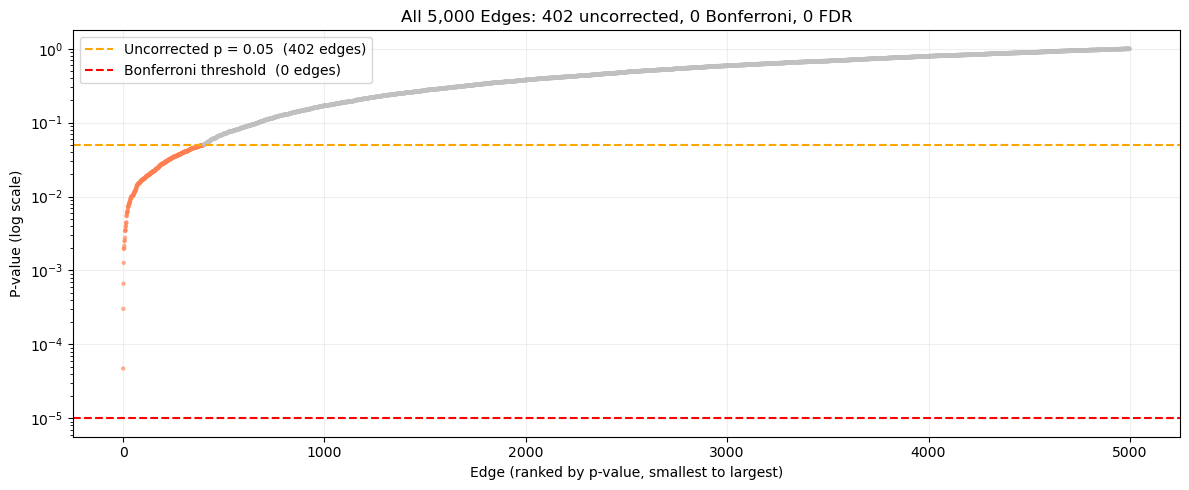

In [106]:
# Ranked p-value plot: every dot is one edge, sorted from smallest to largest p-value
import numpy as np
from statsmodels.stats.multitest import multipletests

n_tests = len(results)
sorted_p = np.sort(results['p'].values)

# Compute thresholds
bonferroni_threshold = 0.05 / n_tests
_, p_fdr, _, _ = multipletests(results['p'].values, alpha=0.05, method='fdr_bh')
n_fdr = (p_fdr < 0.05).sum()
fdr_threshold = results['p'].values[np.where(p_fdr < 0.05)[0]].max() if n_fdr > 0 else None

n_uncorrected = (sorted_p < 0.05).sum()
n_bonf = (sorted_p < bonferroni_threshold).sum()

colors = ['coral' if p < 0.05 else 'silver' for p in sorted_p]

plt.figure(figsize=(12, 5))
plt.scatter(range(n_tests), sorted_p, c=colors, s=5, alpha=0.5)

plt.axhline(0.05, color='orange', linestyle='--', linewidth=1.5,
            label=f'Uncorrected p = 0.05  ({n_uncorrected:,} edges)')
plt.axhline(bonferroni_threshold, color='red', linestyle='--', linewidth=1.5,
            label=f'Bonferroni threshold  ({n_bonf} edges)')
if fdr_threshold is not None:
    plt.axhline(fdr_threshold, color='mediumpurple', linestyle='--', linewidth=1.5,
                label=f'FDR threshold  ({n_fdr} edges)')

plt.yscale('log')
plt.xlabel('Edge (ranked by p-value, smallest to largest)')
plt.ylabel('P-value (log scale)')
plt.title(
    f'All {n_tests:,} Edges: {n_uncorrected:,} uncorrected, '
    f'{n_bonf} Bonferroni, {n_fdr} FDR'
)
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

With this many tests, even FDR is very strict. Is there a way to get a gentler correction?

Yes -- by testing fewer edges. If you can narrow your search to a specific brain network, you reduce the number of tests and make correction much more manageable. In real research, you're expected to have a hypothesis *before* collecting data. If you have a reason to focus on a particular network (based on prior literature), it makes sense to only test those edges.

### Narrow Your Hypothesis: Focus on a Specific Network

Here's the key insight: the correction penalty depends on **how many tests you run**. If instead of testing all 23,220 edges, you focus on a specific brain network, you only test ~200-500 edges. That means a much gentler correction.

You can argue that you have a reason to focus on a particular network (e.g., "the default mode network is involved in rumination and depression" or "subcortical regions process pain and emotion").

Let's try two approaches: first, test all edges **involving** a network (where at least one ROI is in the network), and then test edges **within** a network (where both ROIs are in the network):

In [58]:
# Test all edges INVOLVING a specific network (at least one ROI in the network)
# This tests ~200-500 edges depending on the network
network_results = helpers.test_network_edges('Subcortical', correction='fdr')

# How many survive FDR correction?
n_survive = (network_results['p_corrected'] < 0.05).sum()
print(f"\nFindings surviving FDR correction: {n_survive}")

if n_survive > 0:
    print("\nFDR-corrected significant edges:")
    print(network_results[network_results['p_corrected'] < 0.05][
        ['ROI_A', 'ROI_B', 'r', 'p', 'p_corrected']
    ].to_string())
else:
    print("No edges survived FDR correction -- still too many tests.")

Edges involving Subcortical: 3,320
  Significant at p < 0.05 (uncorrected): 155
  Surviving FDR correction: 0

Findings surviving FDR correction: 0
No edges survived FDR correction -- still too many tests.


You may find that few or no edges survive FDR correction here -- even with fewer tests, the "involving" search still includes hundreds of edges. There's a way to narrow further: test only edges **within** a network (where both ROIs belong to the same network) instead of edges **involving** a network (where at least one ROI belongs to it). This cuts the number of tests down to ~50-120 edges per network.

In [60]:
# What if we test ONLY edges WITHIN a network?
# This tests ~50-120 edges -- much fewer tests, much gentler correction
within_results = helpers.test_network_edges('Subcortical', correction='fdr', within=True)

# How many survive FDR correction?
n_survive = (within_results['p_corrected'] < 0.05).sum()
print(f"\nFindings surviving FDR correction: {n_survive}")

# Let's see the best results even if they don't quite survive
print("\nTop 10 within-network edges (sorted by corrected p-value):")
print(within_results.head(10)[['ROI_A', 'ROI_B', 'r', 'p', 'p_corrected']].to_string())

Within Subcortical: 120
  Significant at p < 0.05 (uncorrected): 9
  Surviving FDR correction: 0

Findings surviving FDR correction: 0

Top 10 within-network edges (sorted by corrected p-value):
     ROI_A   ROI_B         r         p  p_corrected
0   NAc-rh  NAc-lh -0.193227  0.006118     0.539084
1  aTHA-rh  HIP-lh  0.177915  0.011720     0.539084
2  pTHA-lh  PUT-lh -0.174471  0.013477     0.539084
3   AMY-lh  PUT-lh -0.164328  0.020061     0.601829
4    GP-lh  PUT-lh -0.155870  0.027524     0.624088
5   HIP-rh   GP-lh -0.148257  0.036160     0.624088
6   HIP-lh  PUT-lh -0.143640  0.042440     0.624088
7   CAU-rh  HIP-lh -0.142727  0.043785     0.624088
8   NAc-lh  PUT-lh  0.140758  0.046807     0.624088
9  pTHA-rh  AMY-lh -0.129899  0.066756     0.644086


By narrowing to edges *within* a single network, the correction penalty is much smaller. You may see some results that are close to surviving FDR correction but not quite there.

In the next section, you'll learn tools that researchers use to refine results like these -- controlling for confounding variables, handling outliers, and analyzing subgroups. These techniques can push marginal results over the significance threshold.

<span style="color:red">If you found anything significant, or even close to significant, document that in your notes so you can refer to it later.</span>

Include the network you tested, the edges that were significant and most importantly, your interpretation: **why do you think these regions connect to your outcome**? 

If you aren't sure what the region does, simply ask Caleb or paste it into Google or an LLM. If you use an LLM, do not tell it about your outcome variable, just what the region does generally. 

---

## Part 7: Your Analysis Toolkit -- Refining Results

You've found some promising within-network results that are close to significance after FDR correction. Now let's learn tools that researchers use to refine their analyses. Each one is a standard technique -- but they also give you flexibility in how you analyze your data.

All of these tools work with both `plot_edge()` and the mass testing functions (`test_all_edges()`, `test_network_edges()`).

### Covariates: Controlling for Confounding Variables

A **covariate** is a variable you account for ("control for") to see whether a relationship still holds after removing its influence. When you control for a variable, the axes show "residualized" values -- what's left of each variable after statistically removing the influence of the covariate.

**Why does this matter?** Sometimes two variables look related, but the apparent relationship is actually driven by a third variable. Let's see an example with the behavioral data first, then apply the same logic to brain data.

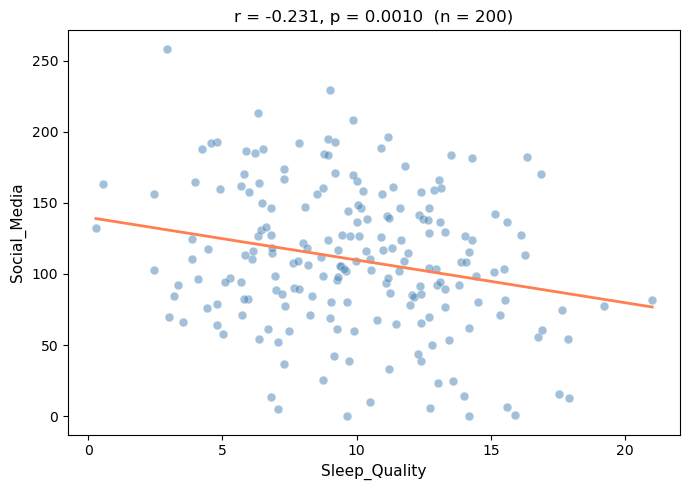

In [62]:
# Are sleep quality and social media use related?
helpers.plot_behavior('Sleep_Quality', 'Social_Media')

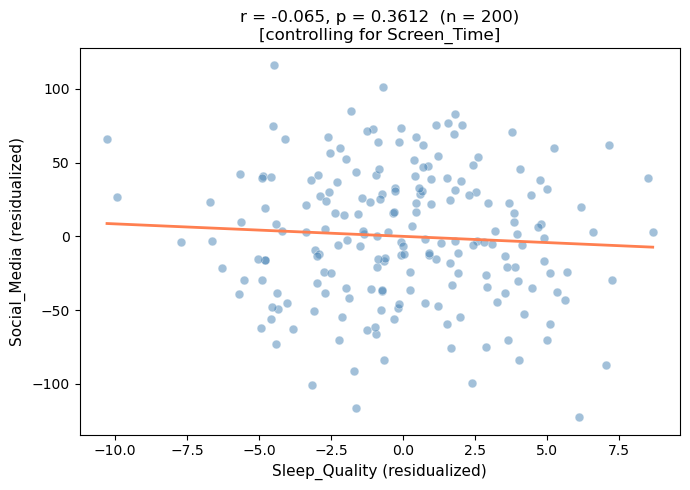

In [64]:
# Hmm, there's a correlation. But could something else be driving both?
# People who spend more time on screens might BOTH sleep worse AND use more social media.
# Let's control for Screen_Time and see what happens:
helpers.plot_behavior('Sleep_Quality', 'Social_Media', covariates=['Screen_Time'])

Notice how the correlation changed after controlling for Screen_Time. Screen time appears to be a **confounding variable** driving both sleep quality and social media use. The same principle applies to brain data -- let's see:

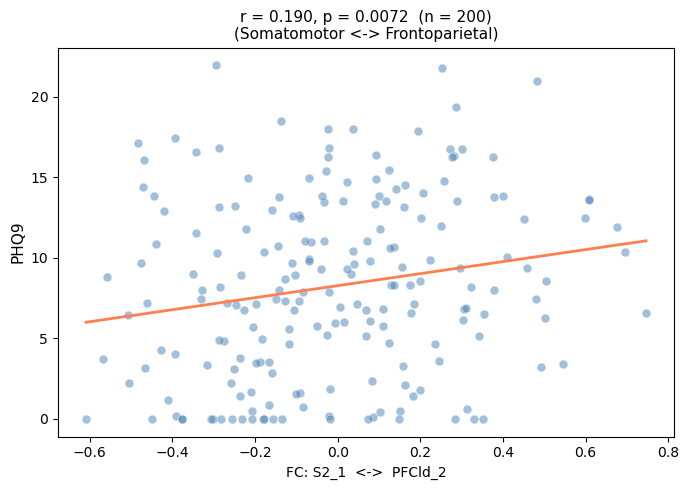

In [66]:
# Pick a demo edge that shows a clear covariate effect for your topic
if TOPIC == 'pain':
    cov_roi_a, cov_roi_b, cov_name = 'LH_DorsAttnA_TempOcc_1', 'RH_VisCent_ExStr_2', 'Stress_Level'
elif TOPIC == 'depression':
    cov_roi_a, cov_roi_b, cov_name = 'LH_SomMotB_S2_1', 'RH_ContB_PFCld_2', 'Stress_Level'
else:  # anxiety
    cov_roi_a, cov_roi_b, cov_name = 'LH_ContB_PFCl_1', 'RH_SalVentAttnA_Ins_1', 'Stress_Level'

# Does this edge predict our outcome?
helpers.plot_edge(cov_roi_a, cov_roi_b)

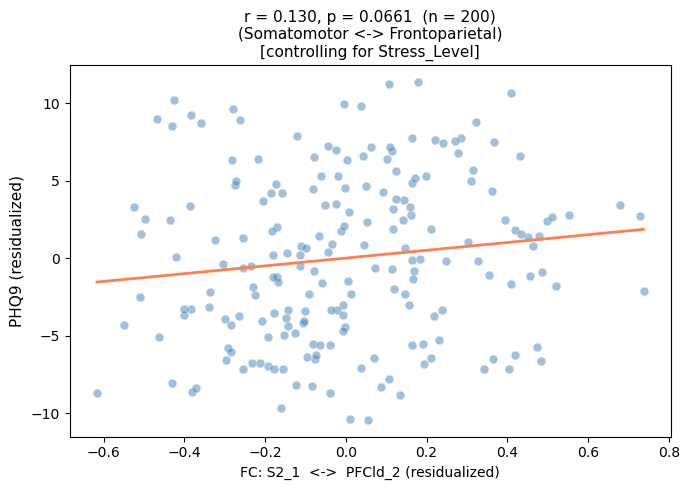

In [68]:
# Now control for the confounding variable and see what happens:
helpers.plot_edge(cov_roi_a, cov_roi_b, covariates=[cov_name])

This edge *appeared* to predict the outcome, but the relationship was partly (or entirely) driven by a confounding variable. After controlling for it, the correlation weakened or vanished.

Covariates can weaken OR strengthen findings. The question is always *which* covariates to include, and whether you chose them before or after seeing your results.

### Outlier Handling

An **outlier** is a data point that is unusually far from the rest. **Z-scores** measure how many standard deviations (SD) a value is from the mean. A z-score of 2 means roughly the most extreme 5% of data; 3 SD is the most extreme 0.3%.

Add an `exclude_outliers` argument to remove extreme connectivity values:

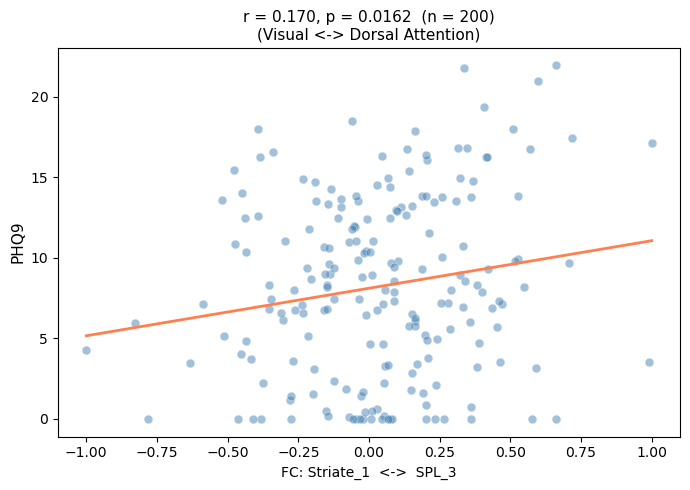

In [70]:
# Pick an edge where outlier removal causes a significant result to disappear
if TOPIC == 'pain':
    out_roi_a, out_roi_b = 'RH_DorsAttnA_SPL_4', 'RH_DefaultA_PFCm_1'
elif TOPIC == 'depression':
    out_roi_a, out_roi_b = 'RH_VisCent_Striate_1', 'RH_DorsAttnA_SPL_3'
else:  # anxiety
    out_roi_a, out_roi_b = 'LH_DefaultB_Temp_1', 'RH_DefaultA_PFCm_1'

# All data -- significant result
helpers.plot_edge(out_roi_a, out_roi_b)

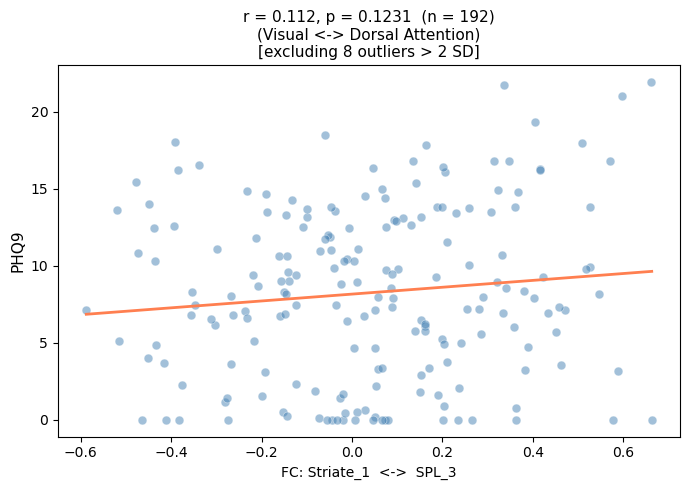

In [72]:
# Remove outliers (> 2 SD from the mean -- the most extreme ~5% of values)
helpers.plot_edge(out_roi_a, out_roi_b, exclude_outliers=2)

A significant finding disappears entirely after removing a small number of outliers -- those few data points were driving the whole effect.

Outlier removal can also work in the **other direction**: a non-significant result can become significant once outliers are removed. Let's see that too:

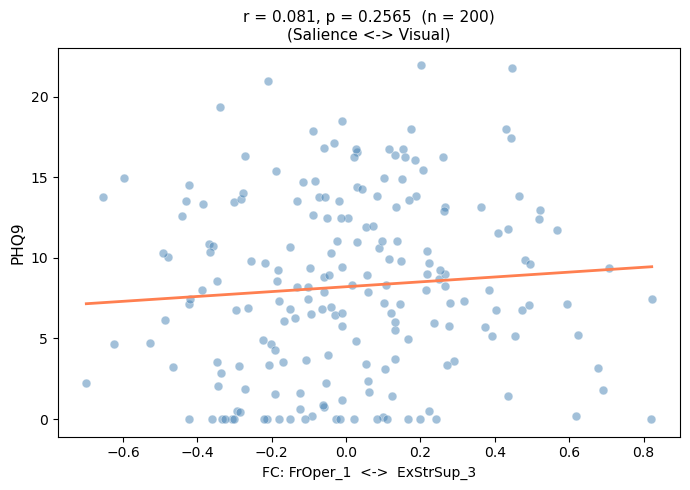

In [74]:
# Pick an edge where outlier removal REVEALS a significant result
if TOPIC == 'pain':
    out2_roi_a, out2_roi_b = 'LH_DorsAttnB_PostC_2', 'RH_ContB_PFCld_3'
elif TOPIC == 'depression':
    out2_roi_a, out2_roi_b = 'LH_SalVentAttnA_FrOper_1', 'RH_VisPeri_ExStrSup_3'
else:  # anxiety
    out2_roi_a, out2_roi_b = 'LH_VisCent_ExStr_2', 'LH_ContA_Cingm_1'

# All data -- not significant
helpers.plot_edge(out2_roi_a, out2_roi_b)

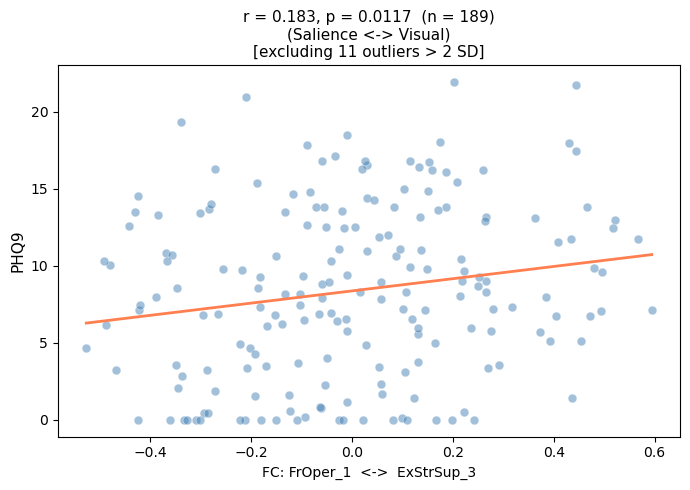

In [76]:
# Remove outliers -- now significant
helpers.plot_edge(out2_roi_a, out2_roi_b, exclude_outliers=2)

Both directions show the same problem: the choice of outlier threshold can make findings appear or disappear. In each direction, only a handful of data points made the difference. The threshold should always be decided **before** looking at the results.

### Subgroup Analysis: Effects Can Differ Across Groups

Relationships can look different depending on who you include. A finding that exists in one group might not exist in another -- or might even reverse.

Let's look at an example: is the relationship between social media use and stress the same for everyone?

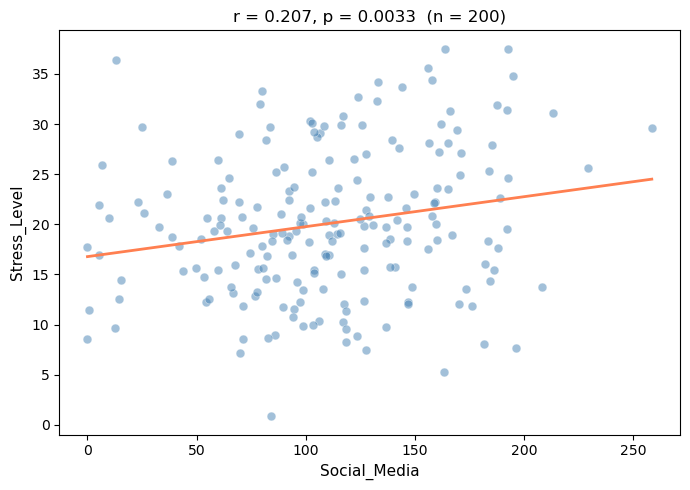

In [78]:
# Overall relationship between social media and stress
helpers.plot_behavior('Social_Media', 'Stress_Level')

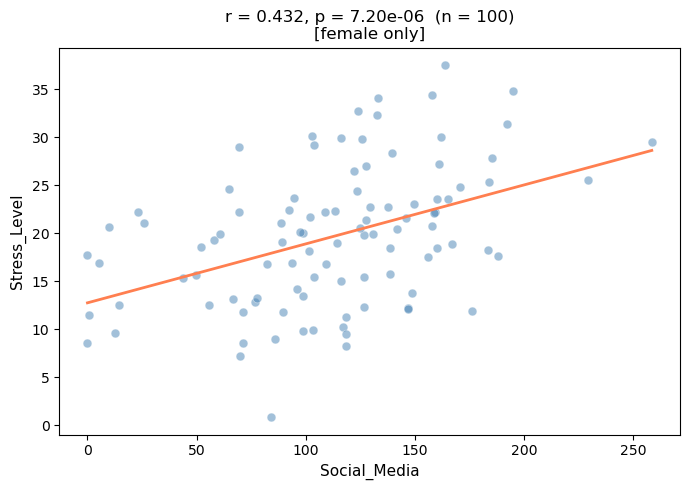

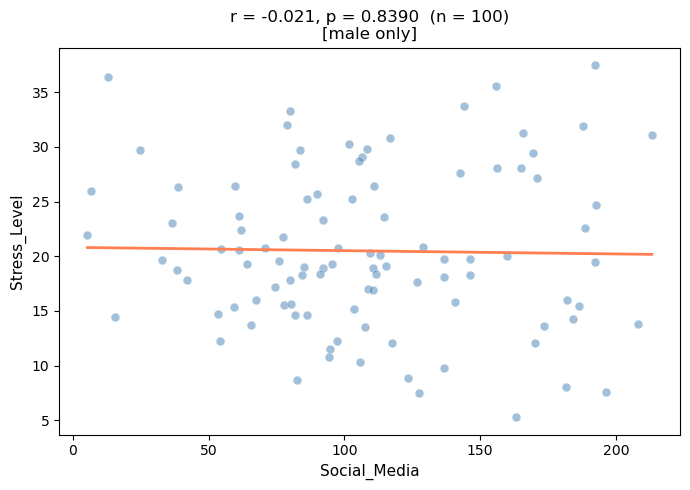

In [80]:
# Does the relationship differ by sex?
helpers.plot_behavior('Social_Media', 'Stress_Level', subgroup={'Sex': 0})  # women
helpers.plot_behavior('Social_Media', 'Stress_Level', subgroup={'Sex': 1})  # men

The overall correlation masks a big difference between groups. This is called **moderation** -- Sex moderates the Social_Media-Stress relationship. The effect looks very different depending on which subgroup you examine.

### Key Takeaway

Covariates, subgroups, and outlier handling are all **legitimate analytical tools** that researchers use every day. Each one can reveal effects that would otherwise be hidden -- or rule out effects that aren't real.

These tools all work with the mass testing functions too. For example:
```python
# Test within-network edges with covariates and FDR correction
helpers.test_network_edges('Default Mode', covariates=['Age'], correction='fdr', within=True)

# Test within a subgroup
helpers.test_network_edges('Subcortical', subgroup={'Sex': 0}, correction='fdr', within=True)
```

You now have a full toolkit for exploring brain-behavior relationships.

**If you update your analysis, make sure to update your lab notes. Which tools did you change, and how did that affect the results?**

---

## Your Task: Find Significant Brain-Behavior Relationships!

Now that you have the tools, your goal is to **discover which functional connections predict your outcome variable**.

### Extra Credit Opportunity!

**<span style="color: red;">The student who finds the strongest, most compelling brain-behavior relationships will receive extra credit.</span>** Strong findings are:
- Statistically significant (low p-values)
- Large effect sizes (strong correlations)
- Well-visualized and clearly presented

Be creative and thorough! Use any of the techniques you learned in Parts 6 and 7.

---

## Part 8: Your Workspace

Use the cells below to explore further and build your case for the strongest findings.

Your goal: find brain-behavior relationships that **survive FDR correction** within a specific network. You have many tools at your disposal:

- Test within a network: `helpers.test_network_edges('Default Mode', correction='fdr', within=True)`
- Add covariates: `helpers.test_network_edges('Default Mode', covariates=['Age'], correction='fdr', within=True)`
- Exclude outliers: `helpers.test_network_edges('Limbic', exclude_outliers=2, correction='fdr', within=True)`
- Analyze subgroups: `helpers.test_network_edges('Salience', subgroup={'Sex': 0}, correction='fdr', within=True)`
- Plot a specific finding: `helpers.plot_edge(top['ROI_A'], top['ROI_B'])`
- Explore behavior relationships: `helpers.plot_behavior('Stress_Level', 'Sleep_Quality')`
- Visualize on glass brain: `helpers.plot_glass_brain(network_results)`

Most students try 5-10 different network/covariate/subgroup combinations before finding something that survives FDR. This is normal. keep exploring!

**As you continue, it will be helpful if you keep adding to your lab notes.**

In [86]:
# Try testing WITHIN a specific network with FDR correction:
network_results = helpers.test_network_edges('Default Mode', correction='fdr', within=True)

# Show any FDR-corrected significant edges
fdr_sig = network_results[network_results['p_corrected'] < 0.05]
if len(fdr_sig) > 0:
    print(f"\n{len(fdr_sig)} edges survived FDR correction!")
    print(fdr_sig[['ROI_A', 'ROI_B', 'r', 'p', 'p_corrected']].to_string())
else:
    print("\nNo edges survived FDR correction. Try a different network, add covariates, or try a subgroup!")

network_results.head()
    
# Try other networks or add refinements:
helpers.test_network_edges('Default', correction='fdr', within=True, exclude_outliers=2)
# helpers.test_network_edges('Subcortical', correction='fdr', within=True)
# helpers.test_network_edges('Frontoparietal', covariates=['Age'], correction='fdr', within=True)

Within Default Mode: 903
  Significant at p < 0.05 (uncorrected): 50
  Surviving FDR correction: 0

No edges survived FDR correction. Try a different network, add covariates, or try a subgroup!
Within Default Mode: 903
  Significant at p < 0.05 (uncorrected): 50
  Surviving FDR correction: 1


,ROI_A,ROI_B,r,p,network_A,network_B,p_corrected
0,LH_DefaultB_PFCd_3,LH_TempPar_2,-0.303292,0.000016,Default Mode,Default Mode,0.014016
1,LH_DefaultA_PFCm_3,RH_TempPar_1,0.252340,0.000360,Default Mode,Default Mode,0.162364
2,LH_DefaultB_Temp_2,RH_DefaultB_AntTemp_1,-0.219069,0.002036,Default Mode,Default Mode,0.427392
3,LH_DefaultC_Rsp_1,RH_TempPar_3,0.216729,0.002280,Default Mode,Default Mode,0.427392
4,RH_DefaultC_IPL_1,RH_TempPar_4,0.215950,0.002367,Default Mode,Default Mode,0.427392
...,...,...,...,...,...,...,...
898,LH_DefaultA_pCunPCC_2,LH_DefaultB_PFCd_3,-0.000469,0.994796,Default Mode,Default Mode,0.998881
899,LH_DefaultC_IPL_1,RH_DefaultC_PHC_1,0.000400,0.995563,Default Mode,Default Mode,0.998881
900,LH_DefaultA_PFCm_2,LH_DefaultB_Temp_2,-0.000272,0.996985,Default Mode,Default Mode,0.999198
901,LH_DefaultC_Rsp_1,LH_TempPar_2,0.000132,0.998532,Default Mode,Default Mode,0.999639


In [84]:
# Your exploration here


In [ ]:
# Plot your top finding, or explore further:
# top = network_results.iloc[0]
# helpers.plot_edge(top['ROI_A'], top['ROI_B'])

# Visualize on glass brain:
# helpers.plot_glass_brain(network_results)


If you want to explore where each region is in the brain, you can use something called `fsleyes`, which is part of a neuroimaging package called FSL. FSL is not on these computers, but you can use neurodesk to use a virtual machine to access it, along with several other neuroimaging programs. 

Here is the link https://neurodesk.org/getting-started/hosted/play/

You will need to sign in with Google account.

Open terminal and type:

`module load fsl`

`wget https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_1mm.nii.gz`

`fsleyes` (takes some time to start)

Then click File > Add standard > MNI152_T1_1mm.nii.gz. This loads up a template brain

Then click File > Add from file > Schaefer2018_200Parcels_7Networks_order_FSLMNI152_1mm.nii.gz (file you just downloaded). This is only cortical.

If you are looking for subcortical areas, load File > Add standard > click on data > atlases > HarvardOxford > anything that says MaxProb and 1mm. 

Click the arrows on the right and set colormap to random. This will make each region a different color. Note that each region has a different number (index).

Use the code below to figure out what the coordinate of your region is, and you can type this into fsleyes to see where it is in the brain. 


In [ ]:
def lookup_roi(name):
      idx, full_name = helpers._resolve_roi(name)
      if idx is None:
          return
      coords = helpers._roi_coords[idx]
      print(f"Name:   {full_name}")
      print(f"Index:  {idx}")
      print(f"Coords: x={coords[0]:.1f}, y={coords[1]:.1f}, z={coords[2]:.1f}  (MNI)")

In [ ]:
lookup_roi('NAc-rh')

---

## Part 9: Prepare Your Presentation

For next class, prepare a brief presentation (5-10 minutes) covering:

1. **Your approach**
   - What networks did you focus on, and why?
   - What analysis decisions did you make (covariates, outliers, subgroups)?

2. **Your top findings**
   - Which brain-behavior relationships survived FDR correction?
   - Show visualizations (scatter plots, glass brain)
   - Report statistics (r values, uncorrected and corrected p-values)

3. **Why you believe your findings**
   - What makes you confident these are real effects?
   - Do the brain regions involved make sense for your topic?

4. **How would you convince a skeptic?**
   - What evidence would you point to?
   - What concerns might someone raise?

**Saving figures:** To save any figure for your presentation, add this line before `plt.show()`:
```python
plt.savefig('my_figure.png', dpi=150, bbox_inches='tight')
```

Or, if you are using the `plot_glass_brain` function, you can add the argument `save_path="FILENAME.png"`

### Submit Your Notebook

When you are finished with Day 1, download this notebook and email it to **caleb_mahlen@urmc.rochester.edu**.

To download from Colab: **File → Download → Download .ipynb**

Your lab notebook notes, code, and any output you have generated will all be saved in the file.